# Moving average
lev_l values have large measurement errors. To avoid predicting errors, we should replace measured raw values by moving average.
#### To fix
- size of window to calculate average
- Null management

[See ISSUE](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/4)

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [4]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [5]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [6]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    equ_df['sleeper_type'] = equ_df['sleeper_type'].replace(sleeper_type_dict)
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [7]:
abcd_list = ['a', 'b', 'c', 'd']
track = {}
equ = {}
for abcd in abcd_list:
    track[abcd] = read_track(abcd)
    equ[abcd] = read_equ(abcd)

track_A shape: (10185690, 9)
equ_A shape: (27906, 9)
track_B shape: (7815753, 9)
equ_B shape: (21531, 9)
track_C shape: (20324660, 9)
equ_C shape: (55684, 9)
track_D shape: (5601687, 9)
equ_D shape: (15691, 9)


### Read predicted data

In [8]:
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
# index_master['kilo'] = index_master['kilo'].astype('str')
submission = pd.read_csv(os.path.join(output_dir, 'lgbm_baseline_20181207.csv'), names=('id', 'lev_l'))

track_pred_tmp = index_master.merge(submission, on='id')
track_pred = {}
for abcd in abcd_list:
    track_pred[abcd] = track_pred_tmp.query('line_name=="{}"'.format(abcd.upper()))

del index_master, submission, track_pred_tmp

## make pivot

In [9]:
def make_lev_df(track):
    lev_df = {}
    for abcd in abcd_list:
        # pivot
        lev_df[abcd] = track[abcd].pivot(index='date', columns='kilo', values='lev_l')
        lev_df[abcd].columns = lev_df[abcd].columns.astype('str')
    return lev_df

In [10]:
lev_df = make_lev_df(track)
lev_pred_df = make_lev_df(track_pred)

## Moving average over days

In [28]:
abcd = 'a'
kilo = '19510'
# lev_diff = lev_diff[abcd]

In [29]:
window_r = 21
min_periods_r = 14

In [30]:
lev_df_ma = lev_df[abcd].rolling(window=window_r, min_periods=min_periods_r, center=True, axis=0).mean()
# lev_df_ma.head(10)

In [31]:
equ[abcd].query('kilo=={}'.format(kilo))

,kilo,is_ballast,is_long,sleeper_type,is_bridge,is_crossing,gross_ton,radius,is_unreliable
9510,19510,0,1,pc,0,0,11.579,4000,1


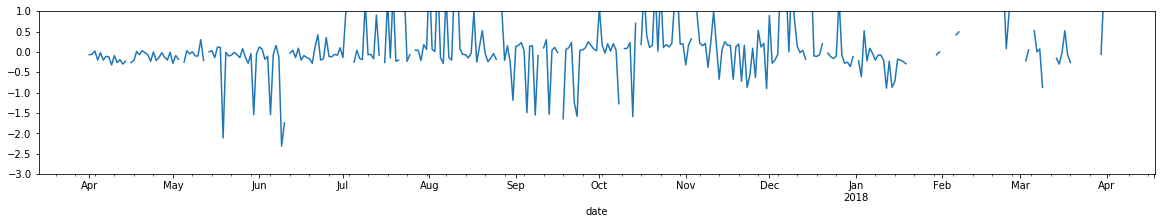

In [32]:
lev_df[abcd][kilo].plot(figsize=(20,3), ylim=(-3, 1))

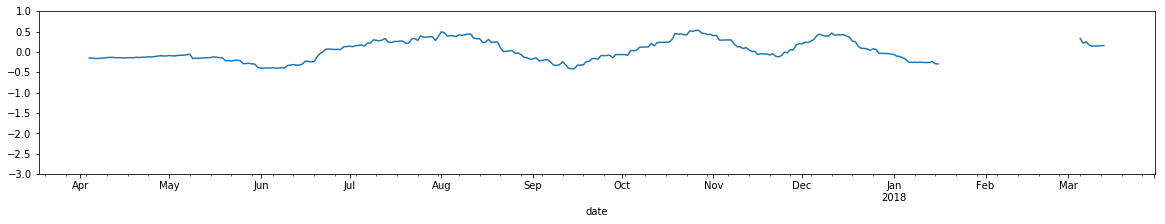

In [33]:
lev_df_ma[kilo].plot(figsize=(20,3), ylim=(-3, 1))

### Pred

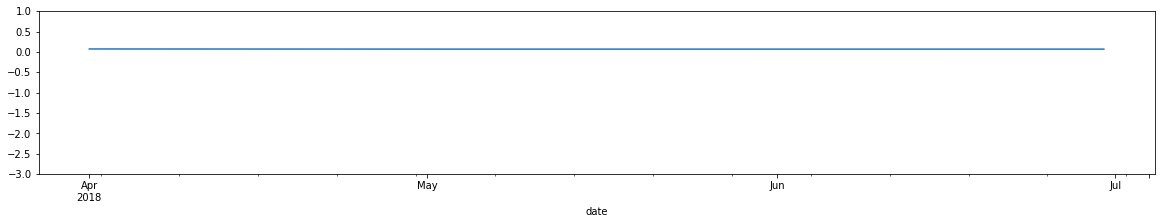

In [34]:
lev_pred_df[abcd][kilo].plot(figsize=(20,3), ylim=(-3, 1))

## Moving average over kilo

In [307]:
abcd = 'b'
date = '2017-10-02'
window_r = 20
min_periods_r = 10
kilo_min = 19000
kilo_scale = 500
kilo_col_list = [str(i) for i in range(kilo_min, kilo_min+kilo_scale)]

In [308]:
lev_df_t = lev_df[abcd][kilo_col_list].T

In [309]:
lev_df_t_ma = lev_df_t.rolling(window=window_r, min_periods=min_periods_r, center=True, axis=0).mean()

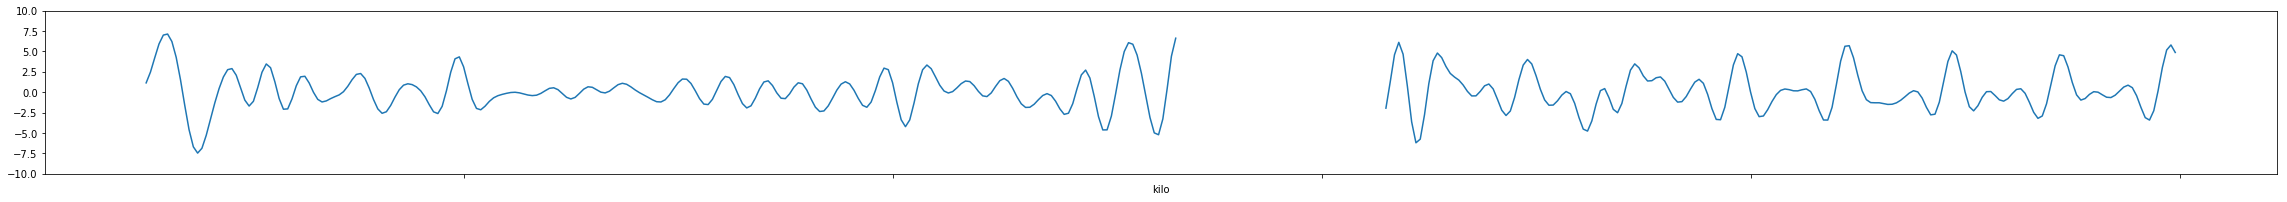

In [310]:
lev_df_t[date].plot(figsize=(40,3), ylim=(-10,10))

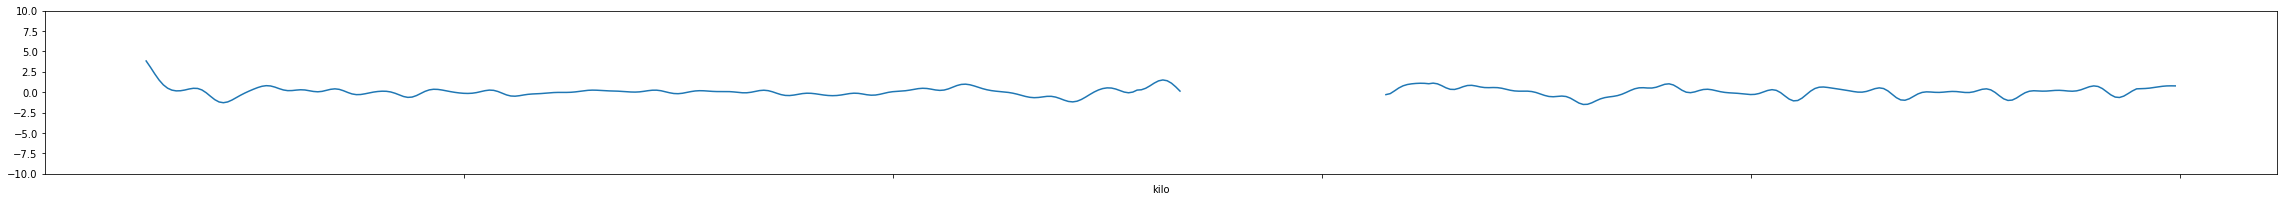

In [311]:
lev_df_t_ma[date].plot(figsize=(40,3), ylim=(-10,10))